# Prediction of Flutter Region on NACA 6410 Airfoils using Machine Learning Algorithms

In this modern day, aircraft has been widely used as a mode of transportation for global travel. These aircraft are meticulously designed to safely carry passengers through the air. Among the aircraft components, wings play a crucial role in enabling an aircraft to fly. They must be designed to have exceptional structural integrity and aerodynamic characteristics. One of the problem rised when designing a wing of an aircraft is flutter. Flutter is an aero-structural phenomenon that should be avoided when designing a wing. An aircraft should fly in the "safe region", that is, the region where flutter does not occur on the wing.

Palar et. al. conducted a numerical experiment investigating the flutter-safe region of a NACA 64A10 airfoil. The study investigates the impact of two design conditions, namely, the Mach number (M) and the flutter speed (Vf), on the value of damping coefficient (DC) of the wing. The value of damping coefficient indicates the occurence of flutter, where negative value indicates its occurence, while positive value suggests its absence. In this article, we will emply various machine learning algorithm to predict the flutter region of the NACA 64A10 airfoil using sample data from Palar et. al.'s study.

In [1]:
# Import main library dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

## Initial Data Inspection

We now may use `pandas` library from Python to read the data from the CSV file and do an initial inspection of the data.

In [2]:
# Read the csv
df = pd.read_csv('data/flutter_data_set.csv')

In [3]:
# Print the first 5 rows of the data
df.head()

,M,Vf,DC
0,0.778,1.696,-0.091831
1,0.667,0.533,0.056686
2,0.750,0.900,0.006096
3,0.700,1.300,0.012506
4,0.667,1.216,0.045172


In [4]:
# Print the last 5 rows of the data
df.tail()

,M,Vf,DC
295,0.850,0.700,-0.023249
296,0.650,0.900,0.048241
297,0.775,0.900,0.018826
298,0.746,0.704,0.044793
299,0.842,0.544,-0.002175


In [5]:
df.describe()
# print(df.describe().to_latex())

,M,Vf,DC
count,300.000000,300.000000,300.000000
mean,0.768178,1.145337,-0.005795
std,0.092958,0.482497,0.039937
min,0.600000,0.400000,-0.104256
25%,0.687750,0.723500,-0.032059
50%,0.772000,1.100000,-0.000651
75%,0.858500,1.554500,0.023531
max,0.905000,2.000000,0.095338


In [6]:
# Print the information for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M       300 non-null    float64
 1   Vf      300 non-null    float64
 2   DC      300 non-null    float64
dtypes: float64(3)
memory usage: 7.2 KB


We can see that we only have 300 rows of data and no null values occur. We can also see that all columns are numerical. We may now proceed to explore the data deeper and gain more insights on the data.

## Exploratory Data Analysis

### Data Distribution

Several methods to visualize the distribution for each column in the data is by using a box-and-whisker plot to identify outliers and a histogram with KDE to visualize skewness. With the `seaborn` library, these plots can be easily created. Even better, the `seaborn` library itself also provides a function to plot bi-variate distribution of each column with another column, which is useful to identify the correlation between each column.

In [7]:
# Function to plot multiple graphs
from math import ceil, sqrt, floor

def mult_dist_plot(df, type='hist'):
    # Get all the columns
    cols = df.columns

    # Calculate needed subplot row and column
    num_rows = ceil(sqrt(len(cols)))
    num_cols = floor(sqrt(len(cols)))

    # Increment col if the total row * col is not enough
    if (num_rows * num_cols < len(cols)):
        num_cols += 1

    # Initiate subplot grid
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_rows*3+2, num_cols*3+2))

    # Flatten the axes array
    axes = axes.flatten()

    # Iterate all over the subplots
    for i, col in enumerate(cols):
        if (type == 'hist'):
            sns.histplot(x=col, data=df, ax=axes[i])
        elif (type == 'box'):
            sns.boxplot(x=col, data=df, ax=axes[i])
        elif (type == 'kde'):
            sns.kdeplot(x=col, data=df, ax=axes[i])
        elif (type == 'hist-kde'):
            sns.histplot(x=col, data=df, ax=axes[i], kde=True)
            
        axes[i].set_title(col)

    # Hide any unused subplots
    for i in range(len(cols), num_rows * num_cols):
        axes[i].axis('off')
    
    # Adjust the spacing between the subplots
    fig.tight_layout()

    # Show the plot
    plt.show()

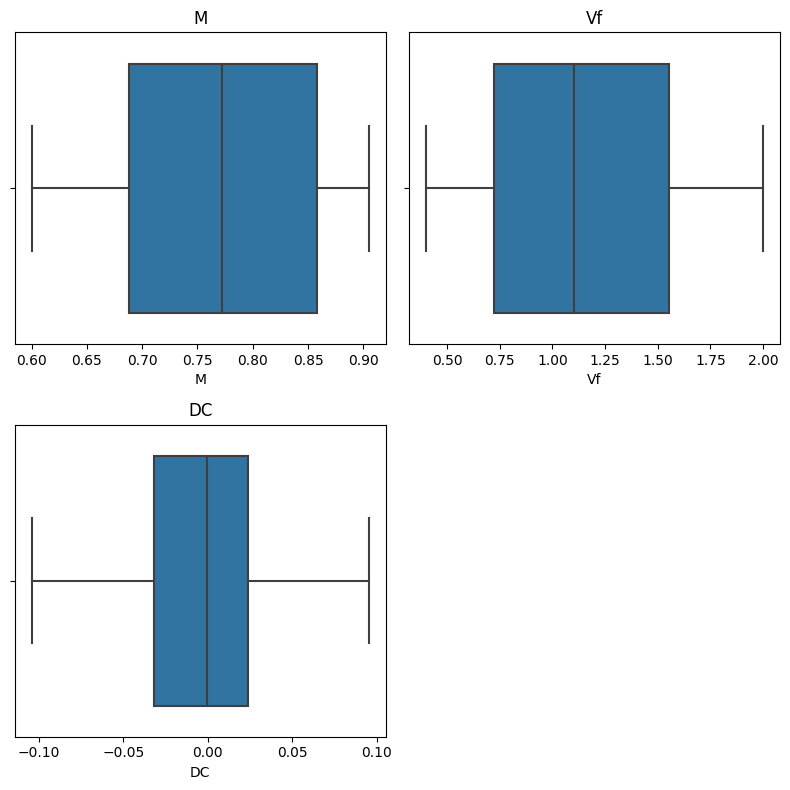

In [8]:
# Plot the boxplot for each column
mult_dist_plot(df, 'box')

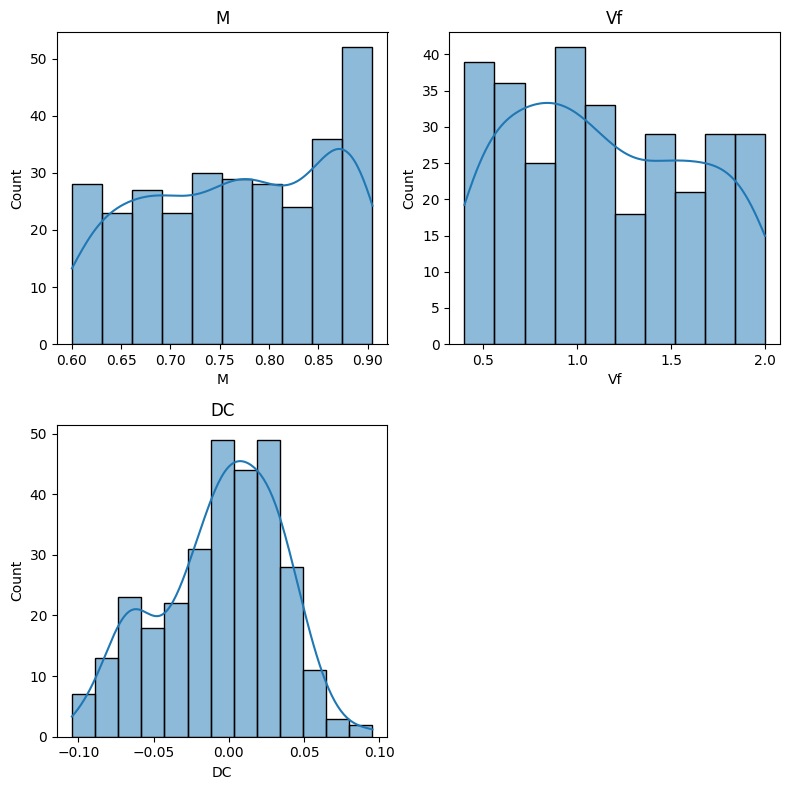

In [9]:
# Plot KDE plot for each column
mult_dist_plot(df, 'hist-kde')

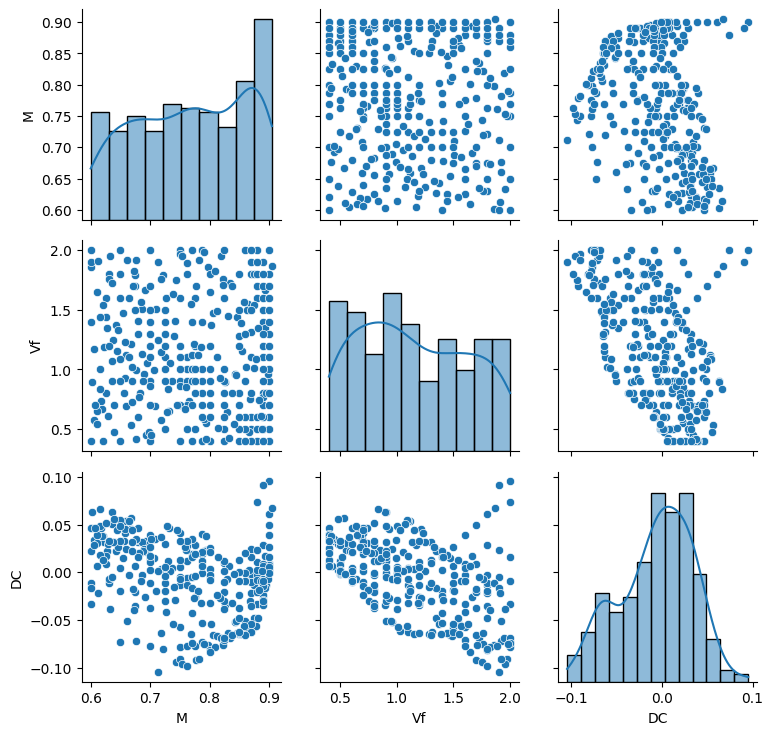

In [10]:
# Use PairGrid to visualize each column relation with others
g = sns.PairGrid(df)
g.map_diag(sns.histplot, kde=True)
g.map_offdiag(sns.scatterplot)
g.add_legend()

plt.savefig("./laporan/graph/case3_data_dist.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case3_data_dist.png", format = 'png', dpi=300, bbox_inches = 'tight')

We can see that the all columns have their data distributed nicely, as there is no outlier in the data. However, from the KDE plot, we can see that all columns have different distribution, and almost all of them are multimodal, and not normally distributed. 

### Data Correlation

We may now compute the correlation matrix of the data to see the correlation between each column using Pearson correlation coefficient. For two random variables $X_1$ and $X_2$ with mean $\mu_{X_1}$ and $\mu_{X_2}$, respectively, the Pearson correlation coefficient is defined as follows:

$$
r = \frac{\sum{(X_1 - \mu_{X_1})(X_2 - \mu_{X_2})}}{\sqrt{\sum{(X_1 - \mu_{X_1})^2}\sum{(X_2 - \mu_{X_2})^2}}}
$$

Here, we use `corr()` function from `pandas` library to compute Pearson correlation coefficient and use heatmap from `seaborn` to visualize it even better.

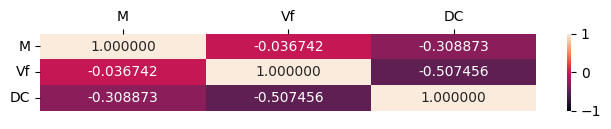

In [11]:
# Plot correlation heatmap
plt.figure(figsize=(8, 1))

# print(df.corr(method="pearson").to_latex)
sns.heatmap(df.corr(method="pearson"), annot=True, vmin=-1, vmax=1, fmt=".6f")

# Change the y-axis rotation
plt.yticks(rotation=0)

# Place x-axis on top
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

# Change the x-tick values
plt.xticks(np.arange(0.5, len(df.columns), 1), ["M", "Vf", "DC"])

# CHange the y-tick values
plt.yticks(np.arange(0.5, len(df.columns), 1), ["M", "Vf", "DC"])

# Export to svg & png
plt.savefig("./laporan/graph/case3_corr_heatmap.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case3_corr_heatmap.png", format = 'png', dpi=300, bbox_inches = 'tight')

# Show the plot
plt.show()

### Scatter Plot

Here, we have two features (M and Vf) and one target (DC). We can visualize the relationship between each feature and the target using scatter plot. We can use 'matplotlib' library to create a 3-dimensional scatter plot. We may also use DC as the color of the scatter plot to see the distribution of the data.

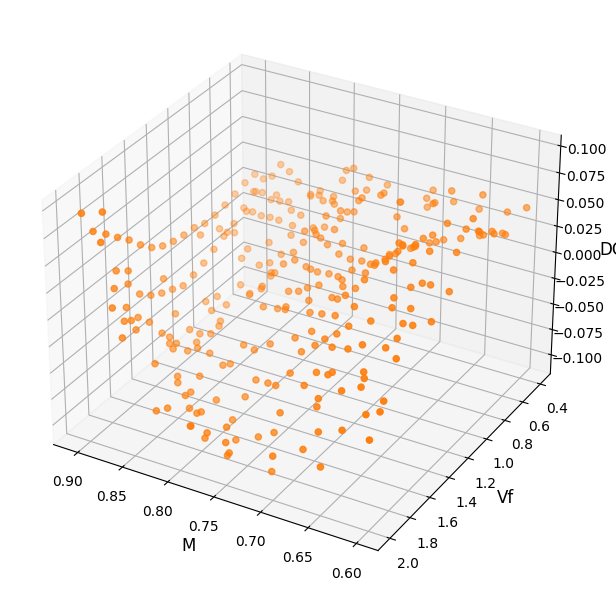

In [12]:
# Create 3D plot
fig = plt.figure(figsize=(7.5, 7.5))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
sample_scatter = ax.scatter(df['M'], df['Vf'], df['DC'], c='tab:orange')

# Set the labels
ax.set_xlabel('M')
ax.set_ylabel('Vf')
ax.set_zlabel('DC')

# Enable rotation and interaction
ax.view_init(azim=120)

# Set the title
# ax.set_title('Sample Scatter Plot')

# Change font size of title and others
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
ax.zaxis.label.set_fontsize(12)
ax.tick_params(axis='both', which='major', labelsize=10)

# Export to png
plt.savefig("./laporan/graph/case3_3d_scatter.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case3_3d_scatter.png", format = 'png', dpi=300, bbox_inches = 'tight')

## Choosing Approach for Prediction

From this point onward, we will prepare the data for machine learning model. However, we need to discuss the strategy to predict flutter occurence on the airfoil. We are given set of numerical data, but are to predict a classification problem. Therefore, for this case, we can have two approaches: 
1. Use regression model to predict the value of DC and then classify the result into two classes, or
2. Use classification model to predict the class of DC directly.

## Approach 1: Regressor Model

For this approach, we have analyzed the data enough to proceed to the next step, which is preprocessing the data before jump to prediction.

### Preprocessing

We need to separate our target column with the rest, which is now our feature. As we're lacking of test dataset to validate our model later, we will split the data into training and test dataset. We will use 80% of the data for training and the rest for testing.

In [13]:
# Split features and target(s)
X = df.drop(['DC'], axis=1)
y = df['DC']

# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Building and Predicting

On this article, we limit the choice of model to: __Linear Regression__ and __K-Nearest Neighbors Regression__.

#### Linear Regression

Linear Regression is one of the simplest machine learning algorithm. It is a regression model that assumes a linear relationship between the input variables ($X$) and the single output variable ($y$). Given a set of input variables $X = (X_1, X_2, \dots, X_p)$ and the output variable $y$, we use the following equation to predict the value of $y$:

$$
y = \beta_0 + \sum_{i=1}^{p}{\beta_i X_i} + \varepsilon
$$

where $\beta_0$ is the intercept, $\beta_i$ is the coefficient representing the slope for the $i$-th feature, and $\varepsilon$ is the error term. We want to estimate $\beta_0$, $\beta_1$, $\dots$, $\beta_p$. 

$$
\hat{y} = \hat{\beta_0} + \sum_{i=1}^{p}{\hat{\beta_i} X_i}
$$

where $\hat{y}$ is our estimation of $y$ and $\hat{\beta_0}$, $\hat{\beta_1}$, $\dots$, $\hat{\beta_p}$ are our estimation of $\beta_0$, $\beta_1$, $\dots$, $\beta_p$, respectively. With our data, we can estimate the value of $\hat{\beta_0}$, $\hat{\beta_1}$, $\dots$, $\hat{\beta_p}$. Let a vector
$$
\boldsymbol{\hat{\beta}} = \begin{bmatrix} \hat{\beta_0} \\ \hat{\beta_1} \\ \vdots \\ \hat{\beta_p} \end{bmatrix}
$$
and an array
$$
\mathbf{X} = \begin{bmatrix} 1 & X_1 & \dots & X_p \end{bmatrix}
$$
and thus our equation becomes:

$$
\hat{y} = \mathbf{X}\boldsymbol{\hat{\beta}}
$$

The value of coefficients in $\boldsymbol{\hat{\beta}}$ is calculated so that our model is the best fit for our data. For this article, we will use **Ordinary Least Squares** method to estimate the value of $\boldsymbol{\hat{\beta}}$. Ordinary Least Squares method minimizes the residual sum of squares (RSS) or the sum of squares estimate of errors (SSE) between the actual value of $y$ and the predicted value of $\hat{y}$. The RSS is defined as,

$$
\textrm{RSS}(\boldsymbol{\hat{\beta}}) = \sum_{i=1}^{n}{(y_i - \hat{y_i})^2} = \sum_{i=1}^{n}{(y_i - \mathbf{X}_i \boldsymbol{\hat{\beta}})^2}
$$

Suppose we have a total of $n$ data points. Let's define vector
$$
\mathbf{y} = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix}
$$
and define
$$
\mathbf{F} = \begin{bmatrix} 1 & X_{11} & \dots & X_{1p} \\ 1 & X_{21} & \dots & X_{2p} \\ \vdots & \vdots & \ddots & \vdots \\ 1 & X_{n1} & \dots & X_{np} \end{bmatrix}
$$

Then, we can rewrite the RSS as follows:
$$
\textrm{RSS}(\boldsymbol{\hat{\beta}}) = (\mathbf{y} - \mathbf{F}\boldsymbol{\hat{\beta}})^T(\mathbf{y} - \mathbf{F}\boldsymbol{\hat{\beta}})
$$

We can minimize the RSS by taking the derivative of RSS with respect to $\boldsymbol{\hat{\beta}}$ and set it to zero. We can do this by using the following equation:

$$
\frac{\partial \textrm{RSS}(\boldsymbol{\hat{\beta}})}{\partial \boldsymbol{\hat{\beta}}} = -2\mathbf{F}^T(\mathbf{y} - \mathbf{F}\boldsymbol{\hat{\beta}}) = 0
$$

Solving the equation above, we get the following equation:

$$
\boldsymbol{\hat{\beta}} = (\mathbf{F}^T\mathbf{F})^{-1}\mathbf{F}^T\mathbf{y}
$$

##### Estimation of Variance #####

After we get the value of $\boldsymbol{\hat{\beta}}$, we can estimate the variance of all those coefficients. The variance of $\boldsymbol{\hat{\beta}}$ is defined as:

$$
\textrm{Var}(\boldsymbol{\hat{\beta}}) = \sigma^2(\mathbf{F}^T\mathbf{F})^{-1}
$$

where $\sigma^2$ is the variance of the error term $\varepsilon$. We can estimate $\sigma^2$ by using $\hat{\sigma}^2$, which is defined as:

$$
\hat{\sigma}^2 = \frac{\textrm{RSS}(\boldsymbol{\hat{\beta}})}{n - p - 1}
$$

where $n$ is the number of data points and $p$ is the number of features.

##### Evaluating the Coefficients
In order to evaluate the coefficients (and consequently the predicted result), we need to conduct a statistical test. For each coefficient, we are going to do as follows:

1. First, we need to calculate the standard error of our coefficients, which is defined as:

$$
\textrm{SE}(\hat{\beta}_j) = \sqrt{\textrm{Var}(\hat{\beta}_j)} 
$$

2. From the standard error, we may have our confidence interval. The confidence interval is defined as:

$$
\hat{\beta}_j \pm t_{\alpha/2} \textrm{SE}(\hat{\beta}_j)
$$

where $\alpha$ is the significance level. 

3. Next, we may define our hypothesis test. We want to test whether the coefficient $\hat{\beta}_j$ is statistically significant or not. Our null hypothesis is that the coefficient of $X_j$ is zero, i.e., doesn't have any effect on $y$ ($H_0: \hat{\beta}_j = 0$) and vice verse for the alternative hypothesis ($H_1: \hat{\beta}_j \neq 0$). 

4. Before jumping even further, let's decide our significance level. In this case, we're going to use $\alpha = 0.05$, or 95% confidence interval.

4. Next, as we only have a sample of the population, we're going to compute a $t$-test. The corresponding $t$-statistic is defined as:

$$
t_j = \frac{\hat{\beta}_j - 0}{\textrm{SE}(\hat{\beta}_j)}
$$

5. As we're doing $t$-test, we need to calculate the degree of freedom ($\nu$). In this case, we have $n$ data points and $p$ features, so the degree of freedom is defined as:

$$
\nu = n - p
$$

6. From the $t$-distribution, we can extract the $p$-value from the $t$-value.

7. Finally, we can have our conclusion based on the $p$-value. $H_0$ can be rejected if $p$-value is less than $\alpha$, which is, for this case, 0.05.

##### Implementation

Next, we're going to implement the linear regression model using the equation above. We will use `BaseEstimator` and `TransformerMixin` from `sklearn.base` to make our own estimator class.

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to for linear regression
class LinearRegression(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        # Calculate number of data points
        self.training_n_ = X.shape[0]

        # Calculate number of variables
        self.p_ = X.shape[1]

        # Compute F by concaneating a column of ones to X
        F = np.c_[np.ones(self.training_n_), X]

        # Compute the estimation of coefficients
        self.beta_ = np.linalg.inv(F.T @ F) @ F.T @ y

        # Separate intercept and coefficient
        self.intercept_ = self.beta_[0]
        self.coef_ = self.beta_[1:]

        # Compute the RSS of beta
        self.RSS_ = np.sum((y - F @ self.beta_)**2)

        # Compute the RSE of beta
        self.RSE_ = np.sqrt(self.RSS_ / (self.training_n_ - self.p_ - 1))

        # Compute the estimation of variance of the model
        self.var_ = self.RSS_ / (self.training_n_ - self.p_ - 1)

        # Compute the estimation of variance of the coefficients
        self.beta_var_ = (self.var_ * np.linalg.inv(F.T @ F)).diagonal()
    
    def predict(self, X):
        # Calculate number of data points
        n = X.shape[0]

        # Compute F
        F = np.c_[np.ones(n), X]

        # Compute the prediction
        y_pred = F @ self.beta_

        return y_pred
    
    def evaluation_report(self, alpha=0.05):
        # Calculate standard error
        beta_se_ = np.sqrt(self.beta_var_)

        # Calculate t-statistic
        t_stat_ = self.beta_ / beta_se_

        # Calculate degree of freedom
        df_ = self.training_n_ - self.p_

        # Calculate p-value
        p_value_ = sp.stats.t.sf(np.abs(t_stat_), df_) * 2

        # Determine hypothesis test result
        hypothesis_test_result_ = np.where(p_value_ < alpha, 'Reject H0', 'Do Not Reject H0')

        # Create a dataframe to store the result
        result = pd.DataFrame({
            "Beta": self.beta_,
            "Standard Error": beta_se_,
            "t-statistic": t_stat_,
            "p-value": p_value_,
            "Hypothesis Test Result": hypothesis_test_result_
        })

        return result

##### Fitting, Predicting, and Evaluating

Next, we're going to use the model to predict the value of DC and visualize the result.

In [15]:
lr = LinearRegression()

# Fit the training data
lr.fit(X_train, y_train)

# Predict the test data
y_pred_lr = lr.predict(X_test)

In [16]:
# Print the evaluation report
lr.evaluation_report()
# print(lr.evaluation_report().to_latex())

,Beta,Standard Error,t-statistic,p-value,Hypothesis Test Result
0,0.158557,0.017985,8.816034,2.555677e-16,Reject H0
1,-0.145096,0.022156,-6.548710,3.543494e-10,Reject H0
2,-0.046859,0.004335,-10.808856,2.045755e-22,Reject H0


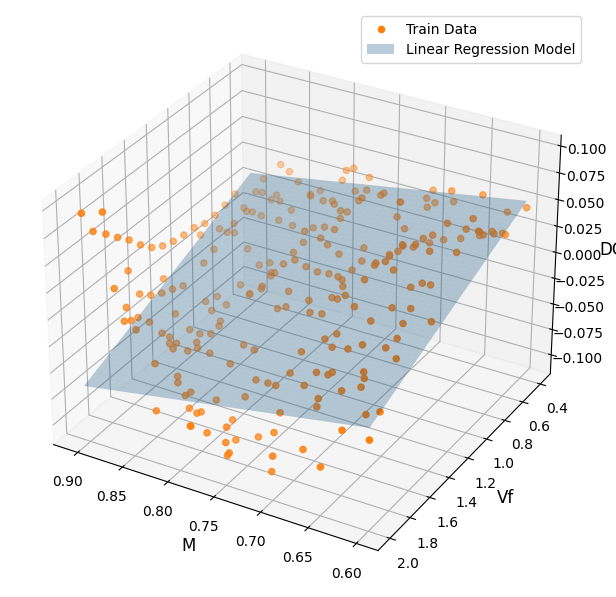

In [17]:
# Plot the result
fig = plt.figure(figsize=(7.5, 7.5))
ax = fig.add_subplot(111, projection='3d')

# Plot the samples with scatter plot
X1 = X_train['M']
X2 = X_train['Vf']
samples_scatter = ax.scatter(X1, X2, y_train, label='Train Data', c='tab:orange')

# Create linear space, meshgrid, and vectors
X1_range = np.linspace(X['M'].min(), X['M'].max(), 100)
X2_range = np.linspace(X['Vf'].min(), X['Vf'].max(), 100)

X1_mesh, X2_mesh = np.meshgrid(X1_range, X2_range)

X1_vec = X1_mesh.reshape(-1,)
X2_vec = X2_mesh.reshape(-1,)

X_vec = np.array([X1_vec, X2_vec]).T
y_vec_lr = lr.predict(X_vec)
y_mesh_lr = y_vec_lr.reshape(X1_mesh.shape)

# Plot the result with surface plot
surf = ax.plot_surface(X1_mesh, X2_mesh, y_mesh_lr, alpha=0.3, label='Linear Regression Model')
surf._facecolors2d=surf._facecolor3d
surf._edgecolors2d=surf._edgecolor3d

# Set the label
ax.set_xlabel('M')
ax.set_ylabel('Vf')
ax.set_zlabel('DC')
# ax.set_title('Linear Regression Model on The Training Data')

# Change label font
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
ax.zaxis.label.set_fontsize(12)

# Show legend
ax.legend()

ax.view_init(azim=120)

# Export to png and svg
plt.savefig("./laporan/graph/case3_lr_plane.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case3_lr_plane.png", format = 'png', dpi=300, bbox_inches = 'tight')

plt.show()

#### K-Nearest Neighbors Regression

K-Nearest Neighbors (KNN) is a well-known machine learning algorithm. It is a supervised learning algorithm that makes predictions based on the similarity of data points in a feature space. It is considered a non-parametric algorithm, that is, does not make string assumptions about the form of the prediction mapping function. It predicts the class label or value of a new data point based on the class labels of its $k$ nearest neighbors in the training dataset. However, scaling the data is mandatory when using KNN as it is sensitive to the scale of the data.

For regression using KNN, the prediction is simply the average of the $k$ nearest neighbors. The following figure illustrates the concept of KNN.

(ilustration)

Three of all main hyperparameters of KNN is $k$ (the number of neighbors), the distance metric, and the weight function. The distance metric is the distance method used in calculating the "distance" between two data points. Three of the most common distance metric are Euclidean distance, Manhattan distance, and Minkowski distance. The weight function is the function used to weight the contribution of each neighbor. The weight function can be uniform, distance, or user-defined.

For this article, we will use Euclidean distance as the distance metric and use Grid Search from `sklearn` library to find the best value of $k$ and the weight function between uniform-weighted and distance-weighted. The score used for this hyperparameter tuning is the RSME score.

We will be using `KNeighborsRegressor` from `sklearn` library to build the model.

##### Hyperparameter Tuning

In [18]:
# Hyperparameter with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

# Create the model
knnr_h = KNeighborsRegressor()

# Create the parameter grid
param_grid = {
    'n_neighbors': [k for k in range(1, 21)]
    # 'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create the grid search
grid = GridSearchCV(knnr_h, param_grid, cv=10, n_jobs=-1, scoring='neg_root_mean_squared_error')

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Fit the grid search
grid.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:")
print(f"{grid.best_params_}")

Best Parameters:
{'n_neighbors': 2}


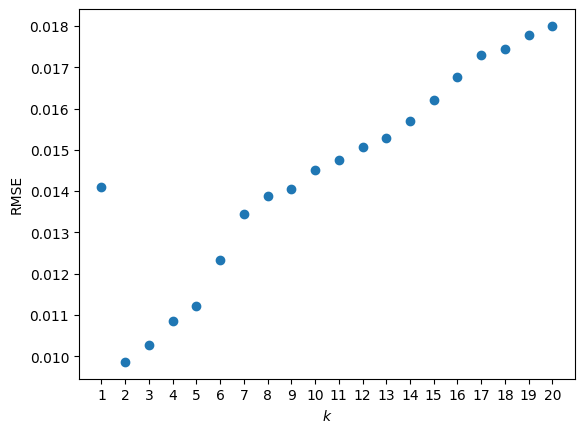

In [19]:
grid_cv_result = pd.DataFrame(grid.cv_results_)

plt.scatter(grid_cv_result['param_n_neighbors'], -grid_cv_result['mean_test_score'])

# Set tick to have increment of 1
plt.xticks(np.arange(1, 21, 1))

# Set the label
plt.xlabel('$k$')
plt.ylabel('RMSE')

# Export to png and svg
plt.savefig("./laporan/graph/case3_knnr_rmse.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case3_knnr_rmse.png", format = 'png', dpi=300, bbox_inches = 'tight')

##### Fitting, Predicting, and Evaluating

In [20]:
# Create the model
knnr = KNeighborsRegressor(**grid.best_params_)

# Fit the model
knnr.fit(X_train_scaled, y_train)

# Scale the test set
X_test_scaled = scaler.transform(X_test)

# Predict the test set
y_pred_knnr = knnr.predict(X_test_scaled)

c:\Users\hafiz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


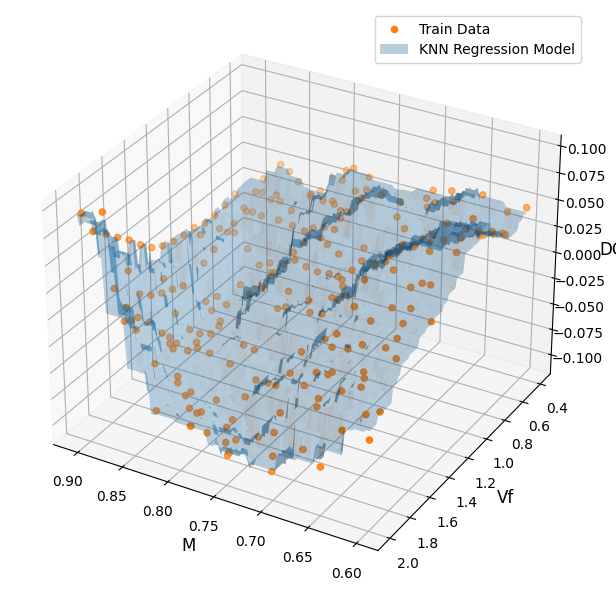

In [21]:
# Plot the result
fig = plt.figure(figsize=(7.5, 7.5))
ax = fig.add_subplot(111, projection='3d')

# Plot the training data with scater plot
# X1_train = X_train['M']
# X2_train = X_train['Vf']
# train_scatter = ax.scatter(X1_train, X2_train, y_train, label='Train Data')

# Plot the test data with scater plot
# X1_test = X_test['M']
# X2_test = X_test['Vf']
# test_scatter = ax.scatter(X1_test, X2_test, y_test, label='Test Data')

# Plot the samples with scatter plot
X1 = X_train['M']
X2 = X_train['Vf']
samples_scatter = ax.scatter(X1, X2, y_train, label='Train Data', c='tab:orange')

# Create linear space, meshgrid, and vectors
X1_range = np.linspace(X['M'].min(), X['M'].max(), 100)
X2_range = np.linspace(X['Vf'].min(), X['Vf'].max(), 100)

X1_mesh, X2_mesh = np.meshgrid(X1_range, X2_range)

X1_vec = X1_mesh.reshape(-1,)
X2_vec = X2_mesh.reshape(-1,)

X_vec = np.array([X1_vec, X2_vec]).T
X_vec_scaled = scaler.transform(X_vec)
y_vec_knnr = knnr.predict(X_vec_scaled)
y_mesh_knnr = y_vec_knnr.reshape(X1_mesh.shape)

# Plot the result with surface plot
surf = ax.plot_surface(X1_mesh, X2_mesh, y_mesh_knnr, alpha=0.3, label='KNN Regression Model')
surf._facecolors2d=surf._facecolor3d
surf._edgecolors2d=surf._edgecolor3d

# Set the label
ax.set_xlabel('M')
ax.set_ylabel('Vf')
ax.set_zlabel('DC')
# ax.set_title('KNN Regression Model on The Training Data')

# Change label font
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
ax.zaxis.label.set_fontsize(12)

# Show legend
ax.legend()

ax.view_init(azim=120)

# Export to png and svg
plt.savefig("./laporan/graph/case3_knnr_plane.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case3_knnr_plane.png", format = 'png', dpi=300, bbox_inches = 'tight')

plt.show()

### Model Evaluation

For this approach, we will first evaluate the result for each prediction using root squared mean error (RMSE) score by comparing it with testing data. We will also visualize the result of the prediction with surface plotting. For linear regression only, we will also evaluate the $R^2$ score when used with training data.

However, as the goal of this article is to predict the flutter region, we will also need to classify the result of the prediction. Therefore. we need to compare classified prediction result with classified testing data. We will be doing this by using confusion matrix and classification report from `sklearn`. With the classification report, we can see the precision, recall, and f1-score of the result. With the confusion matrix, we can see more detailed view about the number of true positive, true negative, false positive, and false negative. We will also visualize the result of the classification with scatter plotting.

#### Root-Squared Mean Error (RMSE)

RMSE is defined as

$$
\textrm{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
$$

where $n$ is the number of data points in the test data, $y_i$ is the actual value of the $i$-th data point, and $\hat{y}_i$ is the predicted value of the $i$-th data point.

In [22]:
# Import the RMSE
from sklearn.metrics import mean_squared_error

# Print RMSE
print("Root Mean Squared Error")
print(f"Linear Regression : {mean_squared_error(y_test, y_pred_lr, squared=False)}")
print(f"KNN Regression : {mean_squared_error(y_test, y_pred_knnr, squared=False)}")

Root Mean Squared Error
Linear Regression : 0.02996890495173782
KNN Regression : 0.007906563318876033


#### Mean Absolute Score (MAE)

MAE is defined as

$$
\textrm{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|

$$

where $n$ is the number of data points in the test data, $y_i$ is the actual value of the $i$-th data point, and $\hat{y}_i$ is the predicted value of the $i$-th data point.

In [23]:
# Import the JAE
from sklearn.metrics import mean_absolute_error

# Print RMSE
print("Root Mean Squared Error")
print(f"Linear Regression : {mean_absolute_error(y_test, y_pred_lr)}")
print(f"KNN Regression : {mean_absolute_error(y_test, y_pred_knnr)}")

Root Mean Squared Error
Linear Regression : 0.01900120499775297
KNN Regression : 0.005573439883333333


#### $R^2$ Score

$R^2$ score is defined as

$$
R^2 = 1 - \frac{\textrm{RSS}}{\textrm{TSS}} =  1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$$

where RSS is the residual sum of squares, TSS is the total sum of squares, $n$ is the number of data points in the training data, $y_i$ is the actual value of the $i$-th data point, $\hat{y}_i$ is the predicted value of the $i$-th data point, and $\bar{y}$ is the mean of the actual value.

In [24]:
# Import the R2 Score
from sklearn.metrics import r2_score

# Print R2 Score
print("R2 Score")
print(f"Linear Regression : {r2_score(y_train, lr.predict(X_train))}")

R2 Score
Linear Regression : 0.39777283907278627


#### RSE Score

RSE score is defined as

$$
\textrm{RSE} = \sqrt{\frac{\textrm{RSS}}{n-p-1}} = \sqrt{\frac{1}{n-p-1}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
$$

where $n$ is the number of data points in the training data, $p$ is the number of features, $y_i$ is the actual value of the $i$-th data point, and $\hat{y}_i$ is the predicted value of the $i$-th data point.

In [25]:
# Print RSE Score
print("RSE Score")
print(f"Linear Regression : {lr.RSE_}")

RSE Score
Linear Regression : 0.0324932433970297


**Interpretation**

Based on the RMSE score, we can see that KNN regression using $k$ neighbors of 3 and distance-weighted function have less RMSE value than linear regression. This indicates that KNN regression is more accurate in predicting the value of damping coefficient than linear regression.

Based on the $R^2$ score, we can see that the linear regression model has low value of $R^2$. This indicates that the linear regression model is not a good fit for the data.

#### Classification Report

The classification report from `sklearn` consists of precision, recall, f1-score, and accuracy. Precision is defined as the ratio of true positive to the sum of true positive and false positive. Recall is defined as the ratio of true positive to the sum of true positive and false negative. F1-score is defined as the harmonic mean of precision and recall. Accuracy is defined as the ratio of true positive and true negative to the sum of true positive, true negative, false positive, and false negative.

In [26]:
# Import classification report
from sklearn.metrics import classification_report

# Classify the prediction
y_test_class = np.where(y_test < 0, "Flutter", "Non-flutter")
y_pred_lr_class = np.where(y_pred_lr < 0, "Flutter", "Non-flutter")
y_pred_knnr_class = np.where(y_pred_knnr < 0, "Flutter", "Non-flutter")

# Print the classification report
print("Classification Report")
print(f"Linear Regression : \n{classification_report(y_test_class, y_pred_lr_class)}")
print(f"KNN Regressor : \n{classification_report(y_test_class, y_pred_knnr_class)}")

Classification Report
Linear Regression : 
              precision    recall  f1-score   support

     Flutter       0.77      0.83      0.80        24
 Non-flutter       0.88      0.83      0.86        36

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60

KNN Regressor : 
              precision    recall  f1-score   support

     Flutter       0.92      0.96      0.94        24
 Non-flutter       0.97      0.94      0.96        36

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



**Interpretation**

Based on the classification report, we can see that KNN regression using $k$ neighbors of 3 and distance-weighted function have higher precision, recall, and f1-score than linear regression. This indicates that KNN regression is a lot better in classifying the flutter region than linear regression.

#### Confusion Matrix

Text(0.5, 1.0, 'K-Nearest Neighbors Regression-Classify Model')

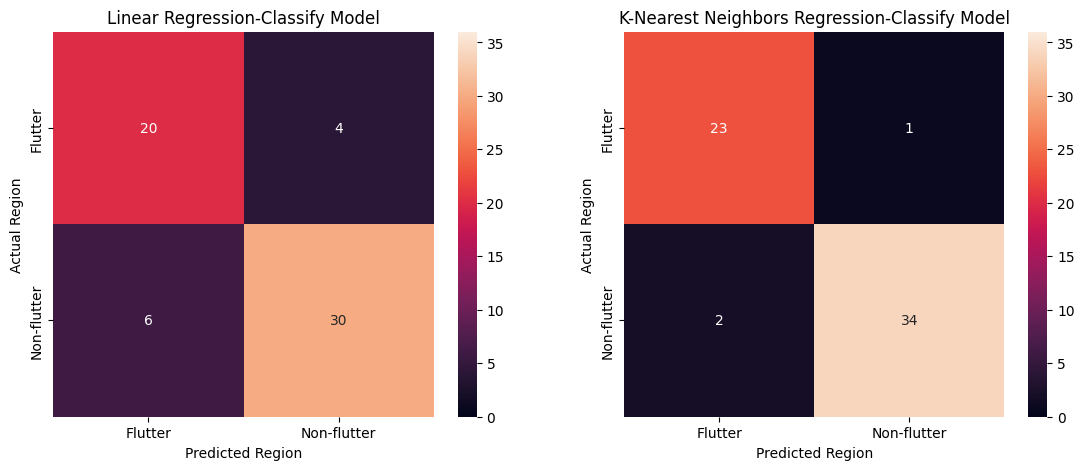

In [27]:
# Import confusion matrix
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
cm_lr = confusion_matrix(y_test_class, y_pred_lr_class)
cm_knnr = confusion_matrix(y_test_class, y_pred_knnr_class)

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(13.5,5))

# Draw the heatmap
sns.heatmap(cm_lr, annot=True, fmt='d', ax=ax[0], vmin=0, vmax=36)
sns.heatmap(cm_knnr, annot=True, fmt='d', ax=ax[1], vmin=0, vmax=36)

# Set x-axis label and ticks 
tick_label = ['Flutter', 'Non-flutter']

ax[0].set_xlabel("Predicted Region")
ax[0].xaxis.set_ticklabels(tick_label)
ax[1].set_xlabel("Predicted Region")
ax[1].xaxis.set_ticklabels(tick_label)

# Set y-axis label and ticks
ax[0].set_ylabel("Actual Region")
ax[0].yaxis.set_ticklabels(tick_label)
ax[1].set_ylabel("Actual Region")
ax[1].yaxis.set_ticklabels(tick_label)

# Set title
ax[0].set_title("Linear Regression-Classify Model")
ax[1].set_title("K-Nearest Neighbors Regression-Classify Model")

#### Scatter Plot

In [28]:
# Create the location of X to visualize
X1_min, X1_max = X['M'].min()-0.0125, X['M'].max()+0.0125
X2_min, X2_max = X['Vf'].min()-0.1, X['Vf'].max()+0.1

h1 = (X1_max-X1_min)/250
h2 = (X2_max-X2_min)/250

# Calculate prediction at each prediction location
XX1, XX2 = np.meshgrid(np.arange(X1_min, X1_max, h1), np.arange(X2_min, X2_max, h2))
X_norm = np.c_[XX1.ravel(), XX2.ravel()]

# Get mesh of predicted result
y_pred_mesh_lr = lr.predict(X_norm)

# For KNN, we need to scale the data first
X_norm_scaled = scaler.transform(X_norm)

# Get mesh of predicted result
y_pred_mesh_knnr = knnr.predict(X_norm_scaled)

# Classify the prediction
y_pred_mesh_lr_class = np.where(y_pred_mesh_lr < 0, 1, 0)
y_pred_mesh_knnr_class = np.where(y_pred_mesh_knnr < 0, 1, 0)

# Reshape the result
y_pred_mesh_lr_class = y_pred_mesh_lr_class.reshape(XX1.shape)
y_pred_mesh_knnr_class = y_pred_mesh_knnr_class.reshape(XX1.shape)

c:\Users\hafiz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


C:\Users\hafiz\AppData\Local\Temp\ipykernel_4768\3103956977.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(flut["M"], flut["Vf"], label='Sample Flutter Data Points', c=cmap(20), edgecolors='k')
C:\Users\hafiz\AppData\Local\Temp\ipykernel_4768\3103956977.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(no_flut["M"], no_flut["Vf"], label='Sample Non-flutter Data Points', c=cmap(0), edgecolors=

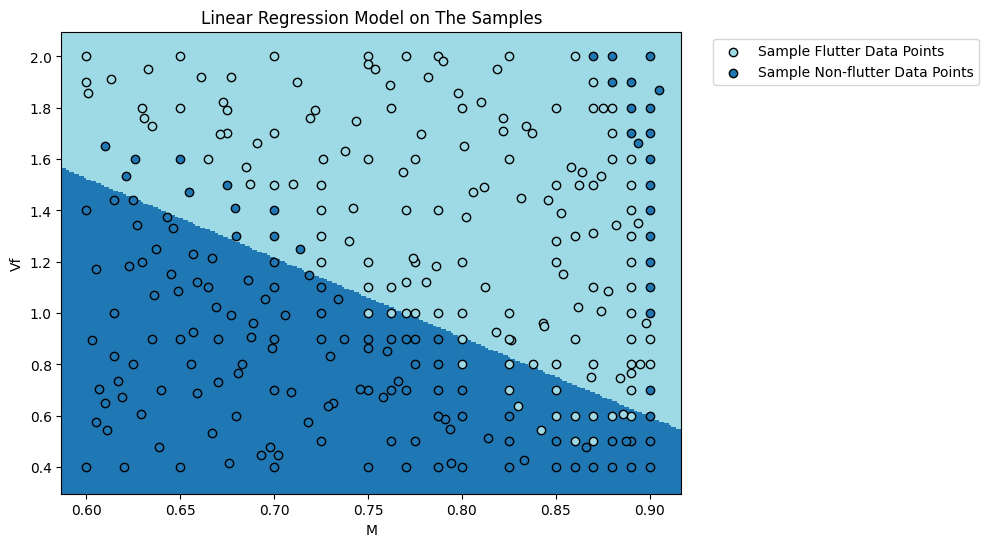

In [29]:
# Formatting the plot figure: color and size
plt.figure(1, figsize=(8, 6))
cmap = plt.cm.tab20
plt.set_cmap(cmap)
plt.pcolormesh(XX1, XX2, y_pred_mesh_lr_class)

# Plotting the result
flut = df.loc[df["DC"] < 0]
no_flut = df.loc[df["DC"] > 0]
plt.scatter(flut["M"], flut["Vf"], label='Sample Flutter Data Points', c=cmap(20), edgecolors='k')
plt.scatter(no_flut["M"], no_flut["Vf"], label='Sample Non-flutter Data Points', c=cmap(0), edgecolors='k')

# Miscellaneous information
plt.xlabel('M')
plt.ylabel('Vf')

plt.title('Linear Regression Model on The Samples')

# Change label font size

plt.legend(bbox_to_anchor=(1.04, 1))

# Export to png and svg
plt.savefig("./laporan/graph/case3_lr_boundary.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case3_lr_boundary.png", format = 'png', dpi=300, bbox_inches = 'tight')


plt.show()

C:\Users\hafiz\AppData\Local\Temp\ipykernel_4768\547803885.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(flut["M"], flut["Vf"], label='Sample Flutter Data Points', c=cmap(20), edgecolors='k')
C:\Users\hafiz\AppData\Local\Temp\ipykernel_4768\547803885.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(no_flut["M"], no_flut["Vf"], label='Sample Non-flutter Data Points', c=cmap(0), edgecolors='k

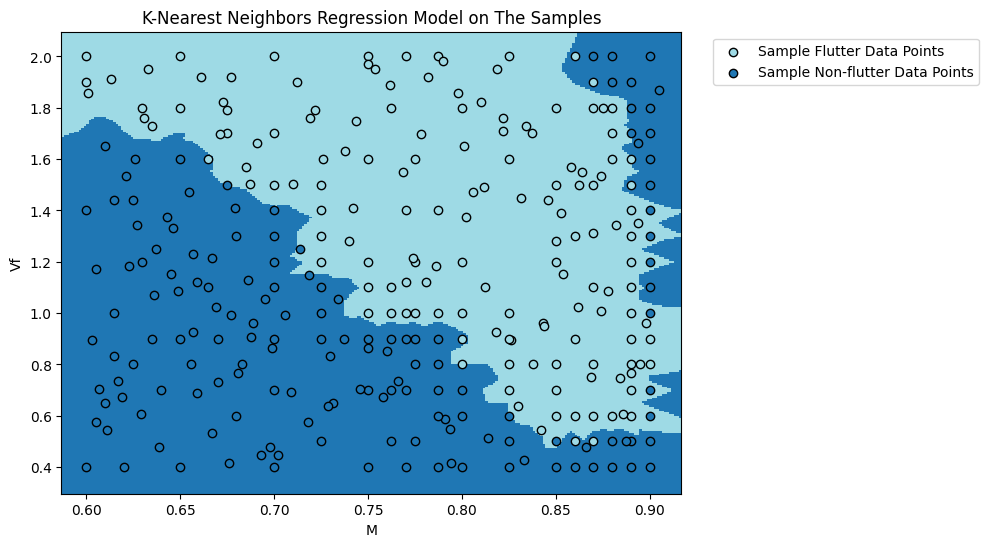

In [30]:
# Formatting the plot figure: color and size
plt.figure(1, figsize=(8, 6))
cmap = plt.cm.tab20
plt.set_cmap(cmap)
plt.pcolormesh(XX1, XX2, y_pred_mesh_knnr_class)

# Plotting the result
flut = df.loc[df["DC"] < 0]
no_flut = df.loc[df["DC"] > 0]
plt.scatter(flut["M"], flut["Vf"], label='Sample Flutter Data Points', c=cmap(20), edgecolors='k')
plt.scatter(no_flut["M"], no_flut["Vf"], label='Sample Non-flutter Data Points', c=cmap(0), edgecolors='k')

# Miscellaneous information
plt.xlabel('M')
plt.ylabel('Vf')

plt.title('K-Nearest Neighbors Regression Model on The Samples')

plt.legend(bbox_to_anchor=(1.04, 1))

# Export the plot
plt.savefig("./laporan/graph/case3_knnr_boundary.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case3_knnr_boundary.png", format = 'png', dpi=300, bbox_inches = 'tight')

plt.show()

## Approach 2: Classiffier Model

For this approach, we have to make a new column that indicates the occurence of flutter in a point. We may also analyze it even further using EDA.

In [31]:
# Create the classifier function
def isFlutter(x):
    if x < 0:
        return "Flutter"

    return "Non-flutter"

df["F"] = df["DC"].apply(isFlutter)

### EDA: Data Distribution

One of things that we may now able to see is the distribution of the data based on the occurence of flutter. We can see the distribution of the data using histogram.

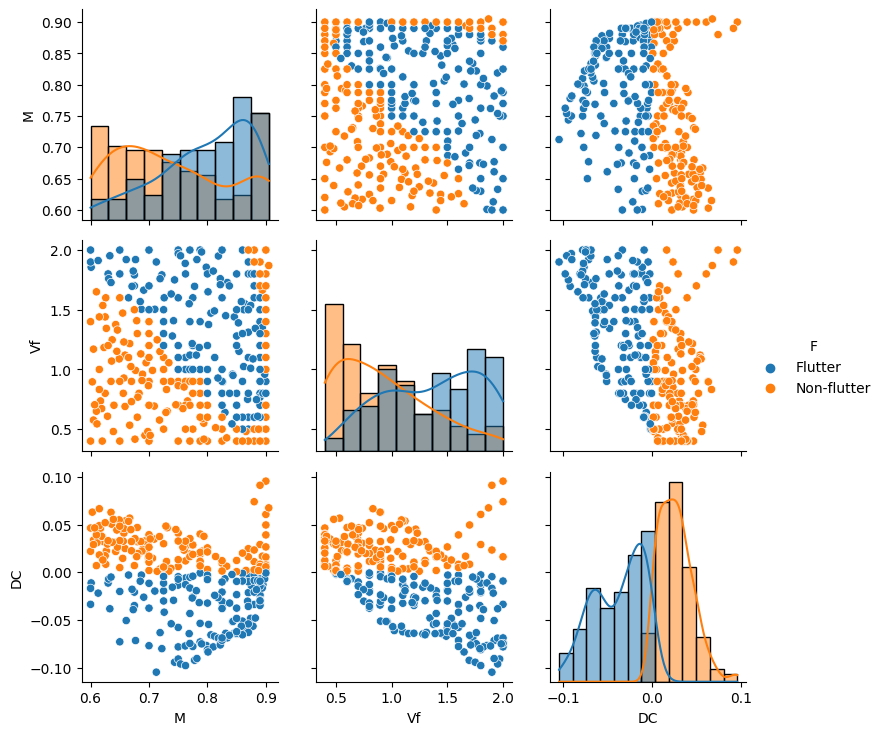

In [32]:
# Use PairGrid to visualize each column relation with others
g = sns.PairGrid(df, hue="F")
g.map_diag(sns.histplot, kde=True)
g.map_offdiag(sns.scatterplot)
g.add_legend()

plt.savefig("./laporan/graph/case3_data_dist_hue.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case3_data_dist_hue.png", format = 'png', dpi=300, bbox_inches = 'tight')

### Preprocessing

Even though we have created a new column, the train-test dataset need to be the same as the previous approach. We only need to classify the target variable into 0 (non-flutter) and 1 (non-flutter).

In [33]:
# Classify the train and test data
y_train_class = np.where(y_train < 0, 1, 0)
y_test_class = np.where(y_test < 0, 1, 0)

### Model Building and Predicting

On this approach, we will use also limit the choice of model to: **Logistic Regression** and **K-Nearest Neighbors Classifier**.

#### Logistic Regression

Don't be fooled with its name. Logistic regression works by using continuous logistic function to predict the probability of the occurence of an event by fitting the data into the logistic curve.

Before we go any further, let's descuss about the logistic curve. The general form of logistic function is:

$$
f(x) = \frac{a}{1 + e^{-b x}}
$$

where $a$ is the curve's maximum value. As we're using logistic function as a probability function, we set $a = 1$ the value of $f(x)$ will be between 0 and 1. The following figure illustrates the logistic curve.

(ilustration)

The mutliple logistic regression model is defined as:

$$
p(X_1, X_2, .., X_p; \boldsymbol{\beta}) = \frac{1}{1 + e^{-\beta_0 - \beta_1 X_1 - \beta_2 X_2 - ... - \beta_p X_p}} = \frac{1}{1 + e^{-\textbf{F}\boldsymbol{\beta}}}
$$

where $p(X_1, X_2, .., X_p; \boldsymbol{\beta})$ is the probability of the occurence of an event, that is, the occurence that the target value $y$ will fall into a default class, with $X_1, X_2, .., X_p$ are the features, $\boldsymbol{\beta} = \left(\beta_0, \beta_1, \beta_2, .., \beta_p\right)^T$ are the coefficients of the features, and

$$
\textbf{F} = \begin{bmatrix}
1 & X_1 & X_2 & \dots & X_p
\end{bmatrix}
$$

After the model has calculated the best value for $\boldsymbol{\beta}$, it will compute a classification task. Usually, logistic regression is used to predict a target variable which have two classes. Therefore, the model will compute a binary classification task. The classification is done by choosing a threshold probability $P$ (usually 0.5) such that if $p(X_1, X_2, .., X_p; \boldsymbol{\beta}) > P$, then the target variable will be classified as the default class, and vice versa for the otherwise.

We now may how to find the best fit values for $\boldsymbol{\beta}$. Unlike linear regression, logistic regression does not predict the value of the target variable. Instead, it predicts the probability of the occurence it falls under a default class. Therefore, methods such as OLS cannot be used to find the best fit values for $\boldsymbol{\beta}$. Therefore, instead, we will use the principle of maximum likelihood to find the best estimation for $\boldsymbol{\beta}$. Likelihood of a set of $\boldsymbol{\beta}$ is defined as:

$$
\textrm{L}(\boldsymbol{\beta}) = \prod_{i:y_i = 1} p(\textbf{F}_i; \boldsymbol{\beta}) \prod_{i:y_{i} = 0} (1 - p(\textbf{F}_i; \boldsymbol{\beta})) = \prod_{i=1}^{n} p\left(\textbf{F}_i; \boldsymbol{\beta}\right)^{y_i} \left(1 - p\left(\textbf{F}_i; \boldsymbol{\beta}\right)\right)^{1 - y_i}
$$

where $p(\textbf{F}_i; \beta)$ is the probability of the occurence of an event for the $i$-th data point. The best estimation for $\boldsymbol{\beta}$ is the one that maximizes the likelihood function. However, it is easier to maximize the log-likelihood function:

$$
\ln \left(\textrm{L}(\boldsymbol{\beta})\right) = \sum_{i=1}^{n} \left(y_i \textbf{F}_i \boldsymbol{\beta} - \ln \left(1 + e^{\textbf{F}_i \boldsymbol{\beta}}\right)\right)
$$

The best estimation for $\boldsymbol{\beta}$ is the one that maximizes the log-likelihood function (MLE). The first derivative of the log-likelihood function is:

$$
\frac{\partial \ln \left(\textrm{L}(\boldsymbol{\beta})\right)}{\partial \boldsymbol{\beta}} = \sum_{i=1}^{n} \left(y_i - p\left(\textbf{F}_i; \boldsymbol{\beta}\right)\right) \textbf{F}_i
$$

The maximum likelihood estimation for $\boldsymbol{\beta}$ is $\boldsymbol{\hat{\beta}}$, that is, the one that minimize above equation (i.e., $\frac{\partial \ln \left(\textrm{L}(\boldsymbol{\hat{\beta}})\right)}{\partial \boldsymbol{\beta}} = 0$). However, there is no closed-form solution for this equation. Therefore, numerical solution is needed to solve this problem. 

One of the most popular numerical solution for this problem is the Newton-Raphson method. The Newton-Raphson method is an iterative method that uses the first derivative of a function to find the root of the function. The general form of the Newton-Raphson method is:

$$
x_{i+1} = x_i - \frac{f(x_i)}{f'(x_i)}
$$

where $x_i$ is the $i$-th iteration, $f(x_i)$ is the function that we want to find the root of, and $f'(x_i)$ is the first derivative of $f(x_i)$. In our case, $x_i \equiv \boldsymbol{\beta}_i$ and $f(x_i) \equiv \frac{\partial \ln \left(\textrm{L}(\boldsymbol{\beta})\right)}{\partial \boldsymbol{\beta}}$. Therefore, we need first to compute the second derivative of the log-likelihood function:

$$
\frac{\partial^2 \ln \left(\textrm{L}(\boldsymbol{\beta})\right)}{\partial \boldsymbol{\beta}\ \partial \boldsymbol{\beta}^T} = - \sum_{i=1}^{n} p\left(\textbf{F}_i; \boldsymbol{\beta}\right) \left(1 - p\left(\textbf{F}_i; \boldsymbol{\beta}\right)\right) \textbf{F}_i \textbf{F}_i^T
$$

and thus the Newton-Raphson method for MLE for logistic regression is:

$$
\boldsymbol{\hat{\beta}}_{i+1} = \boldsymbol{\hat{\beta}}_i - \left(\frac{\partial^2 \ln \left(\textrm{L}(\boldsymbol{\hat{\beta}})\right)}{\partial \boldsymbol{\beta}\ \partial \boldsymbol{\beta}^T}\right)^{-1} \left(\frac{\partial \ln \left(\textrm{L}(\boldsymbol{\hat{\beta}})\right)}{\partial \boldsymbol{\beta}}\right)^T
$$

##### Algorithm for MLE to find the best $\boldsymbol{\hat{\beta}}$
$\boldsymbol{\hat{\beta}} \gets \mathbf{0}$

$\textrm{L} \gets \sum_{i=1}^{n} \left(y_i \textbf{F}_i \boldsymbol{\hat{\beta}} - \ln \left(1 + e^{\textbf{F}_i \boldsymbol{\beta}}\right)\right)$

$\textrm{L}_{\textrm{prev}} \gets 0$

$\epsilon \gets 10^{-6}$

$\textrm{while}\ \left|\textrm{L} - \textrm{L}_{\textrm{prev}}\right| > \epsilon$

$\quad \boldsymbol{\hat{\beta}} \gets \boldsymbol{\hat{\beta}} - \left(\frac{\partial^2 \ln \left(\textrm{L}(\boldsymbol{\hat{\beta}})\right)}{\partial \boldsymbol{\beta}\ \partial \boldsymbol{\beta}^T}\right)^{-1} \left(\frac{\partial \ln \left(\textrm{L}(\boldsymbol{\hat{\beta}})\right)}{\partial \boldsymbol{\beta}}\right)^T$

$\quad \textrm{L}_{\textrm{prev}} \gets \textrm{L}$

$\quad \textrm{L} \gets \sum_{i=1}^{n} \left(y_i \textbf{F}_i \boldsymbol{\hat{\beta}} - \ln \left(1 + e^{\textbf{F}_i \boldsymbol{\hat{\beta}}}\right)\right)$

##### Evaluating the Coefficients
Same as linear regression, we need to evaluate each cofficient by conducting a statistical test. For each coefficient, we are going to do as follows:

1. First, we need to calculate the variance of our coefficients. According to ..., the variance of the coefficients is estimated as the negative value of the corresponding diagonal element of the inverse of the Hessian matrix, i.e.,

$$
\textrm{Var}(\hat{\beta}_j) = - \left(\mathbf{H}^{-1}\right)_{jj}
$$

where $\mathbf{H}$ is the Hessian matrix.

2. Then, we need to calculate the standard error of our coefficients, which is defined as:

$$
\textrm{SE}(\hat{\beta}_j) = \sqrt{\textrm{Var}(\hat{\beta}_j)} 
$$

3. From the standard error, we may have our confidence interval. The confidence interval is defined as:

$$
\hat{\beta}_j \pm t_{\alpha/2} \textrm{SE}(\hat{\beta}_j)
$$

where $\alpha$ is the significance level. 

4. Next, we may define our hypothesis test. We want to test whether the coefficient $\hat{\beta}_j$ is statistically significant or not. Our null hypothesis is that the coefficient of $X_j$ is zero, i.e., doesn't have any effect on $y$ ($H_0: \hat{\beta}_j = 0$) and vice verse for the alternative hypothesis ($H_1: \hat{\beta}_j \neq 0$). 

5. Before jumping even further, let's decide our significance level. In this case, we're going to use $\alpha = 0.05$, or 95% confidence interval.

6. Next, as we only have a sample of the population, we're going to compute a $t$-test. The corresponding $t$-statistic is defined as:

$$
t_j = \frac{\hat{\beta}_j - 0}{\textrm{SE}(\hat{\beta}_j)}
$$

7. As we're doing $t$-test, we need to calculate the degree of freedom ($\nu$). In this case, we have $n$ data points and $p$ features, so the degree of freedom is defined as:

$$
\nu = n - p
$$

8. From the $t$-distribution, we can extract the $p$-value from the $t$-value.

9. Finally, we can have our conclusion based on the $p$-value. $H_0$ can be rejected if $p$-value is less than $\alpha$, which is, for this case, 0.05.

##### Implementation

Next, we're going to implement the logistic regression model using all equations above. We will use `BaseEstimator` and `TransformerMixin` from `sklearn.base` to make our own estimator class.

In [34]:
# Create a class for logistic regression
class LogisticRegression(BaseEstimator, TransformerMixin):
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # Calculate number of data points
        self.training_n_ = X.shape[0]

        # Calculate number of variables
        self.p_ = X.shape[1]

        # Compute F by concaneating a column of ones to X
        F = np.c_[np.ones(self.training_n_), X]

        # Initialize beta
        self.beta_ = np.zeros(self.p_ + 1)

        # Initialize log-likelihood for the initial beta and the log-likelihood array
        self.ll_ = 0
        self.ll_array_ = []
        for i in range(self.training_n_):
            self.ll_ += y[i] * (F[i] @ self.beta_) - np.log(1 + np.exp(F[i] @ self.beta_))

        # Initialize previous log-likelihood
        self.ll_prev_ = 0

        # Initialize and stop error
        self.stop_error_ = 1e-6

        # Do the loop
        while (abs(self.ll_ - self.ll_prev_) > self.stop_error_):
            # Update previous log-likelihood
            self.ll_prev_ = self.ll_
            
            # Calculate the first derivative of log-likelihood
            self.dl_ = np.zeros(self.p_ + 1)
            for i in range(self.training_n_):
                self.dl_ += (y[i] - self.sigmoid(F[i] @ self.beta_)) * F[i]

            # Calculate the second derivative of log-likelihood
            self.ddl_ = np.zeros((self.p_ + 1, self.p_ + 1))
            for i in range(self.training_n_):
                self.ddl_ -= self.sigmoid(F[i] @ self.beta_) * (1 - self.sigmoid(F[i] @ self.beta_)) * np.outer(F[i], F[i])

            # Update beta
            self.beta_ = self.beta_ - np.linalg.inv(self.ddl_) @ self.dl_

            # Update log-likelihood
            self.ll_ = 0
            for i in range(self.training_n_):
                self.ll_ += y[i] * (F[i] @ self.beta_) - np.log(1 + np.exp(F[i] @ self.beta_))

            # Update log-likelihood array
            self.ll_array_ = np.append(self.ll_array_, self.ll_)
            
        # Compute the estimation of variance of the coefficients
        self.beta_var_ = -np.diag(np.linalg.inv(self.ddl_))

    def predict(self, X):
        # Calculate number of data points
        n = X.shape[0]

        # Compute F by concaneating a column of ones to X
        F = np.c_[np.ones(n), X]

        # Initialize prediction
        y_pred = np.zeros(n)

        # Do the loop
        for i in range(n):
            # Calculate the probability of the data point
            prob = self.sigmoid(F[i] @ self.beta_)

            # Classify the data point
            if prob > 0.5:
                y_pred[i] = 1

        return y_pred
    
    def evaluation_report(self, alpha=0.05):
        # Calculate standard error
        beta_se_ = np.sqrt(self.beta_var_)

        # Calculate t-statistic
        t_stat_ = self.beta_ / beta_se_

        # Calculate degree of freedom
        df_ = self.training_n_ - self.p_

        # Calculate p-value
        p_value_ = sp.stats.t.sf(np.abs(t_stat_), df_) * 2

        # Determine hypothesis test result
        hypothesis_test_result_ = np.where(p_value_ < alpha, 'Reject H0', 'Do Not Reject H0')

        # Create a dataframe to store the result
        result = pd.DataFrame({
            "Beta": self.beta_,
            "Standard Error": beta_se_,
            "t-statistic": t_stat_,
            "p-value": p_value_,
            "Hypothesis Test Result": hypothesis_test_result_
        })

        return result

##### Fitting, Predicting, and Evaluating

In [35]:
logit = LogisticRegression()

# Fit the model
logit.fit(X_train, y_train_class)

# Predict the test data
y_pred_logit = logit.predict(X_test)

In [36]:
# Print the evaluation report
logit.evaluation_report()
print(logit.evaluation_report().to_latex)

<bound method NDFrame.to_latex of         Beta  Standard Error  t-statistic       p-value Hypothesis Test Result
0 -12.125372        1.810795    -6.696160  1.526069e-10              Reject H0
1  11.550371        2.013056     5.737728  2.903569e-08              Reject H0
2   2.972623        0.416997     7.128642  1.204635e-11              Reject H0>


In [37]:
# Get mesh of predicted result
y_pred_mesh_logit = logit.predict(X_norm)

# Reshape the result
y_pred_mesh_logit = y_pred_mesh_logit.reshape(XX1.shape)

C:\Users\hafiz\AppData\Local\Temp\ipykernel_4768\3680463935.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(flut["M"], flut["Vf"], label='Sample Flutter Data Points', c=cmap(20), edgecolors='k')
C:\Users\hafiz\AppData\Local\Temp\ipykernel_4768\3680463935.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(no_flut["M"], no_flut["Vf"], label='Sample Non-flutter Data Points', c=cmap(0), edgecolors=

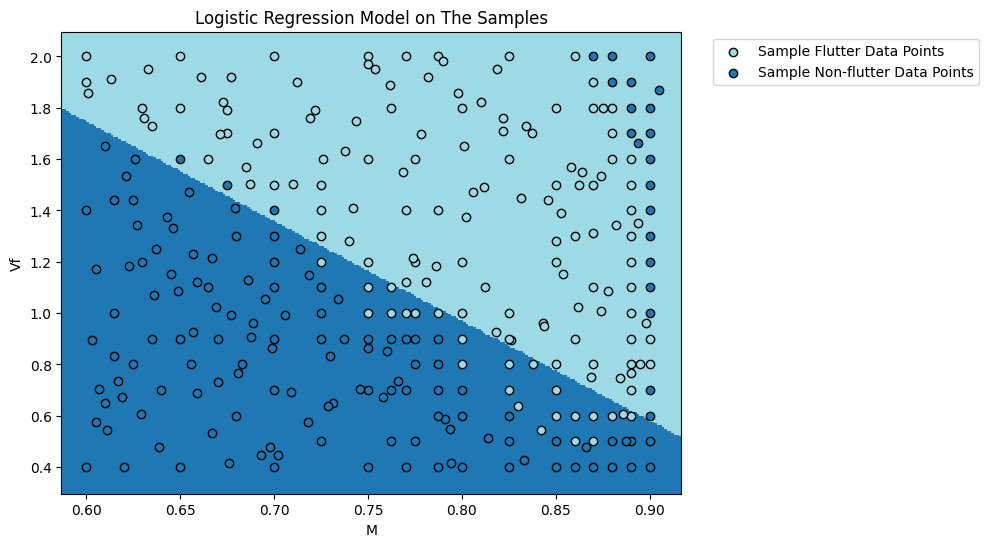

In [38]:
# Formatting the plot figure: color and size
plt.figure(1, figsize=(8, 6))
cmap = plt.cm.tab20
plt.set_cmap(cmap)
plt.pcolormesh(XX1, XX2, y_pred_mesh_logit)

# Plotting the result
flut = df.loc[df["DC"] < 0]
no_flut = df.loc[df["DC"] > 0]
plt.scatter(flut["M"], flut["Vf"], label='Sample Flutter Data Points', c=cmap(20), edgecolors='k')
plt.scatter(no_flut["M"], no_flut["Vf"], label='Sample Non-flutter Data Points', c=cmap(0), edgecolors='k')

# Miscellaneous information
plt.xlabel('M')
plt.ylabel('Vf')

plt.title('Logistic Regression Model on The Samples')

plt.legend(bbox_to_anchor=(1.04, 1))

# Export to png and svg
plt.savefig("./laporan/graph/case3_logit_boundary.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case3_logit_boundary.png", format = 'png', dpi=300, bbox_inches = 'tight')

plt.show()

#### K-Nearest Neighbors Classifier

The concept of K-Nearest Neighbors (KNN) algorithm has already explained when we're using the regressor model. For this approach, we will be using the classifier model. The difference between the regressor and classifier model is that the classifier model will predict the class label of a new data point based on the class labels of its $k$ nearest neighbors in the training dataset. The class label is determined by majority vote. The following figure illustrates the concept of KNN.

(ilustration)

The hyperparameters of KNN classifier is the same as the regressor model, which is $k$ (the number of neighbors), the distance metric, and the weight function. For the classifier model, we will also hyperparameter tune the value of $k$ and the weight function between uniform-weighted and distance-weighted with Grid Search from `sklearn` library and use Euclidean distance for the distance metric. The score used for this hyperparameter tuning is the f1-score (we will discussing it latter why this score is chosen).

We will be using `KNeighborsClassifier` from `sklearn` library to build the model.

##### Hyperparameter Tuning

In [39]:
# Hyperparameter with GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Create the model
knnc_h = KNeighborsClassifier()

# Create the parameter grid
param_grid = {
    'n_neighbors': [k for k in range(1, 21)],
    # 'weights': ['uniform', 'distance'],
    # 'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create the grid search
grid = GridSearchCV(knnc_h, param_grid, cv=10, n_jobs=-1, scoring='f1')

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Fit the grid search
grid.fit(X_train_scaled, y_train_class)

# Print the best parameters
print("Best Parameters:")
print(f"{grid.best_params_}")

Best Parameters:
{'n_neighbors': 3}


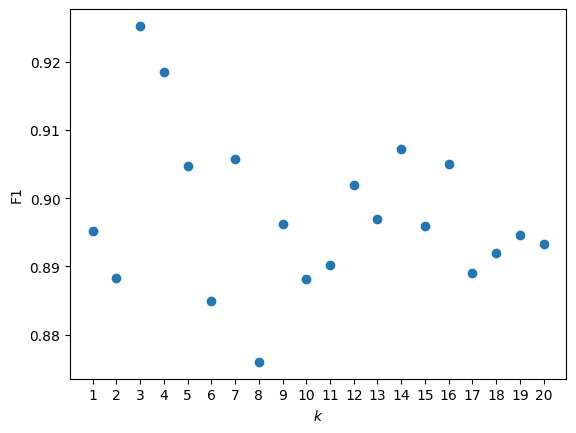

In [40]:
grid_cv_result = pd.DataFrame(grid.cv_results_)

plt.scatter(grid_cv_result['param_n_neighbors'], grid_cv_result['mean_test_score'])

# Set tick to have increment of 1
plt.xticks(np.arange(1, 21, 1))

# Set the label
plt.xlabel('$k$')
plt.ylabel('F1')

# Export to png and svg
plt.savefig("./laporan/graph/case3_knnc_f1.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case3_knnc_f1.png", format = 'png', dpi=300, bbox_inches = 'tight')

##### Fitting, Predicting, and Evaluating

In [41]:
# Create the model
knnc = KNeighborsClassifier(**grid.best_params_)

# Fit the model
knnc.fit(X_train_scaled, y_train_class)

# Scale the test set
X_test_scaled = scaler.transform(X_test)

# Predict the test set
y_pred_knnc = knnc.predict(X_test_scaled)

In [42]:
# Get mesh of predicted result
y_pred_mesh_knnc = knnc.predict(X_norm_scaled)

# Reshape the result
y_pred_mesh_knnc = y_pred_mesh_knnc.reshape(XX1.shape)

C:\Users\hafiz\AppData\Local\Temp\ipykernel_4768\2879514246.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(flut["M"], flut["Vf"], label='Sample Flutter Data Points', c=cmap(20), edgecolors='k')
C:\Users\hafiz\AppData\Local\Temp\ipykernel_4768\2879514246.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(no_flut["M"], no_flut["Vf"], label='Sample Non-flutter Data Points', c=cmap(0), edgecolors=

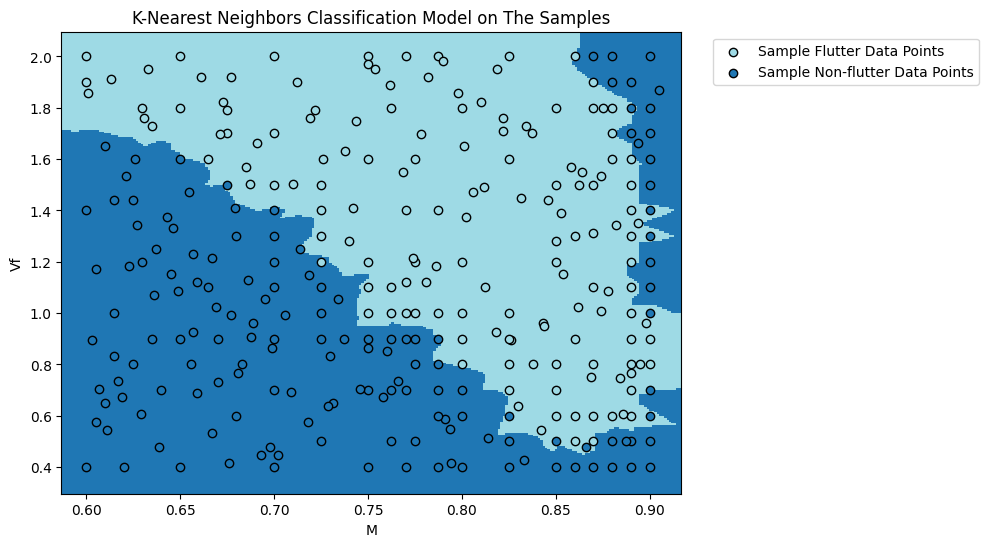

In [43]:
# Formatting the plot figure: color and size
plt.figure(1, figsize=(8, 6))
cmap = plt.cm.tab20
plt.set_cmap(cmap)
plt.pcolormesh(XX1, XX2, y_pred_mesh_knnc)

# Plotting the result
flut = df.loc[df["DC"] < 0]
no_flut = df.loc[df["DC"] > 0]
plt.scatter(flut["M"], flut["Vf"], label='Sample Flutter Data Points', c=cmap(20), edgecolors='k')
plt.scatter(no_flut["M"], no_flut["Vf"], label='Sample Non-flutter Data Points', c=cmap(0), edgecolors='k')

# Miscellaneous information
plt.xlabel('M')
plt.ylabel('Vf')

plt.title('K-Nearest Neighbors Classification Model on The Samples')

plt.legend(bbox_to_anchor=(1.04, 1))

# Export to png and svg
plt.savefig("./laporan/graph/case3_knnc_boundary.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case3_knnc_boundary.png", format = 'png', dpi=300, bbox_inches = 'tight')

plt.show()

### Model Evaluation

For this approach, we will immediately evaluate the result for each prediction using classification report by comparing it with testing data. For logistic regression only, we will also evaluate its pseudo-$R^2$ score.

#### Pseudo-$R^2$ Score

The pseudo-$R^2$ score is used to evaluate the goodness of fit of the logistic regression model. The pseudo-$R^2$ score is defined as:



#### Classification Report

In [44]:
# Classify the prediction
y_test_class_string = np.where(y_test_class == 1.00, "Flutter", "Non-flutter")
y_pred_logit_class = np.where(y_pred_logit == 1.00, "Flutter", "Non-flutter")
y_pred_knnc_class = np.where(y_pred_knnc == 1.00, "Flutter", "Non-flutter")

# Print the classification report
print("Classification Report")
print(f"Logistic Regression : \n{classification_report(y_test_class_string, y_pred_logit_class)}")
print(f"KNN Classification : \n{classification_report(y_test_class_string, y_pred_knnc_class)}")

Classification Report
Logistic Regression : 
              precision    recall  f1-score   support

     Flutter       0.74      0.71      0.72        24
 Non-flutter       0.81      0.83      0.82        36

    accuracy                           0.78        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.78      0.78      0.78        60

KNN Classification : 
              precision    recall  f1-score   support

     Flutter       0.86      1.00      0.92        24
 Non-flutter       1.00      0.89      0.94        36

    accuracy                           0.93        60
   macro avg       0.93      0.94      0.93        60
weighted avg       0.94      0.93      0.93        60



**Interpretation**

Based on the classification report, we can see that KNN classification using $k$ neighbors of 9 and distance-weighted function have higher precision, recall, and f1-score than linear regression. This indicates that KNN classification is a lot better in classifying the flutter region than logistic regression.

#### Confusion Matrix

Text(0.5, 1.0, 'K-Nearest Neighbors Classification Model')

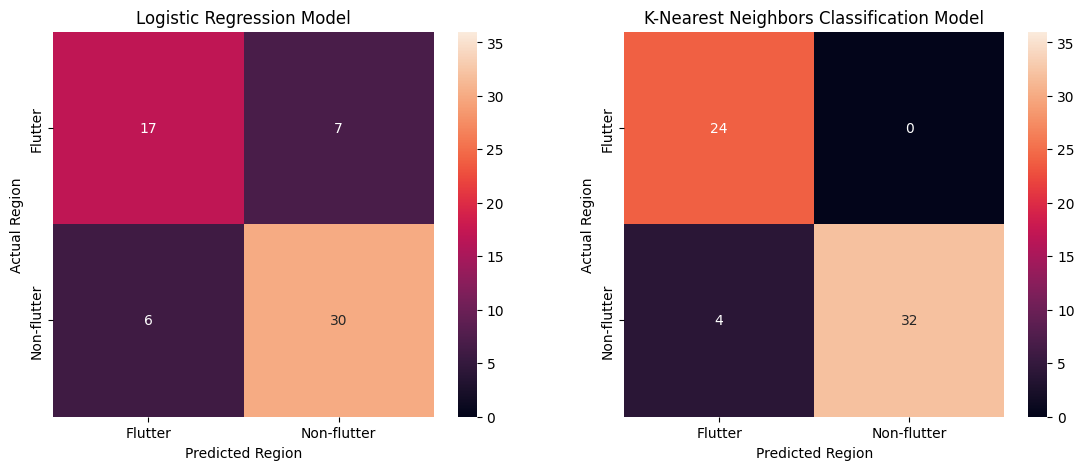

In [45]:
# Print the confusion matrix
cm_logit = confusion_matrix(y_test_class_string, y_pred_logit_class)
cm_knnc = confusion_matrix(y_test_class_string, y_pred_knnc_class)

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(13.5,5))

# Draw the heatmap
sns.heatmap(cm_logit, annot=True, fmt='d', ax=ax[0], vmin=0, vmax=36)
sns.heatmap(cm_knnc, annot=True, fmt='d', ax=ax[1], vmin=0, vmax=36)

# Set x-axis label and ticks 
tick_label = ['Flutter', 'Non-flutter']

ax[0].set_xlabel("Predicted Region")
ax[0].xaxis.set_ticklabels(tick_label)
ax[1].set_xlabel("Predicted Region")
ax[1].xaxis.set_ticklabels(tick_label)

# Set y-axis label and ticks
ax[0].set_ylabel("Actual Region")
ax[0].yaxis.set_ticklabels(tick_label)
ax[1].set_ylabel("Actual Region")
ax[1].yaxis.set_ticklabels(tick_label)

# Set title
ax[0].set_title("Logistic Regression Model")
ax[1].set_title("K-Nearest Neighbors Classification Model")

## Comparing both Approaches

Both approach results in KNN algorithm as the better model, compared to a linear model of Linear Regression and binary classification of probability distribution of Logistic Regression.

Comparing the result of both KNN, it seems that classifying the result of KNN regressor is better than KNN classifier. This can be seen from the accuracy, precision, recall, and f1-score of both KNN. This is due to KNN regressor predicts the true value of damping coefficient, while KNN classifier predicts only the signs of the damping coefficient (which indicates the flutter occurances). By predicting using only the signs of a value, we ignore the magnitude of the value, which is can be quite important (for example, there are more neighbor data points classified as non-flutter region than the flutter region, but their absolute damping coefficient value is much lower than the flutter region). Hence, using regression and classifying the result gave us a better result than classifying the result directly.

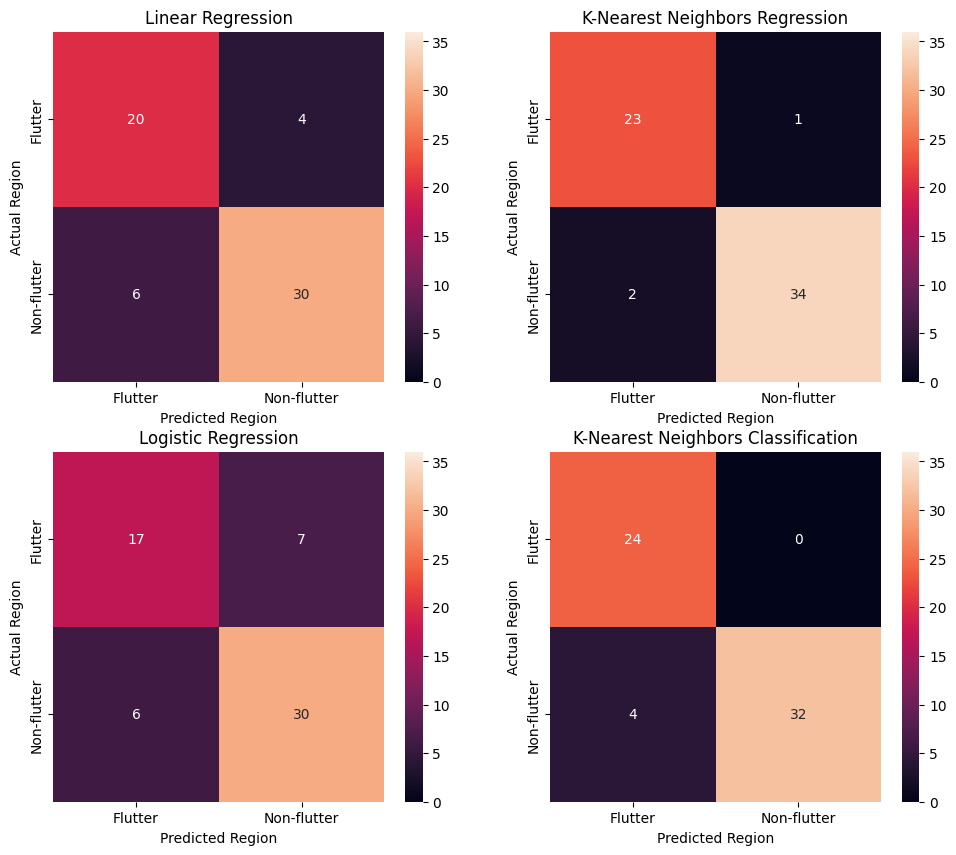

In [46]:
# Initialize figure
fig, ax = plt.subplots(2, 2, figsize=(11.75,10))

# Draw the heatmap
sns.heatmap(cm_lr, annot=True, fmt='d', ax=ax[0][0], vmin=0, vmax=36)
sns.heatmap(cm_knnr, annot=True, fmt='d', ax=ax[0][1], vmin=0, vmax=36)
sns.heatmap(cm_logit, annot=True, fmt='d', ax=ax[1][0], vmin=0, vmax=36)
sns.heatmap(cm_knnc, annot=True, fmt='d', ax=ax[1][1], vmin=0, vmax=36)

# Set x-axis label and ticks 
tick_label = ['Flutter', 'Non-flutter']

ax[0][0].set_xlabel("Predicted Region")
ax[0][0].xaxis.set_ticklabels(tick_label)
ax[0][1].set_xlabel("Predicted Region")
ax[0][1].xaxis.set_ticklabels(tick_label)
ax[1][0].set_xlabel("Predicted Region")
ax[1][0].xaxis.set_ticklabels(tick_label)
ax[1][1].set_xlabel("Predicted Region")
ax[1][1].xaxis.set_ticklabels(tick_label)

# Set y-axis label and ticks
ax[0][0].set_ylabel("Actual Region")
ax[0][0].yaxis.set_ticklabels(tick_label)
ax[0][1].set_ylabel("Actual Region")
ax[0][1].yaxis.set_ticklabels(tick_label)
ax[1][0].set_ylabel("Actual Region")
ax[1][0].yaxis.set_ticklabels(tick_label)
ax[1][1].set_ylabel("Actual Region")
ax[1][1].yaxis.set_ticklabels(tick_label)

# Set title
ax[0][0].set_title("Linear Regression")
ax[0][1].set_title("K-Nearest Neighbors Regression")
ax[1][0].set_title("Logistic Regression")
ax[1][1].set_title("K-Nearest Neighbors Classification")

# Export to png and svg
plt.savefig("./laporan/graph/case3_confusion.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case3_confusion.png", format = 'png', dpi=300, bbox_inches = 'tight')

plt.show()

C:\Users\hafiz\AppData\Local\Temp\ipykernel_4768\352681072.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax_lr.scatter(no_flut["M"], no_flut["Vf"], label='Sample Non-flutter Data Points', c=cmap(0), edgecolors='k')
C:\Users\hafiz\AppData\Local\Temp\ipykernel_4768\352681072.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax_lr.scatter(flut["M"], flut["Vf"], label='Sample Flutter Data Points', c=cmap(20), edgecolor

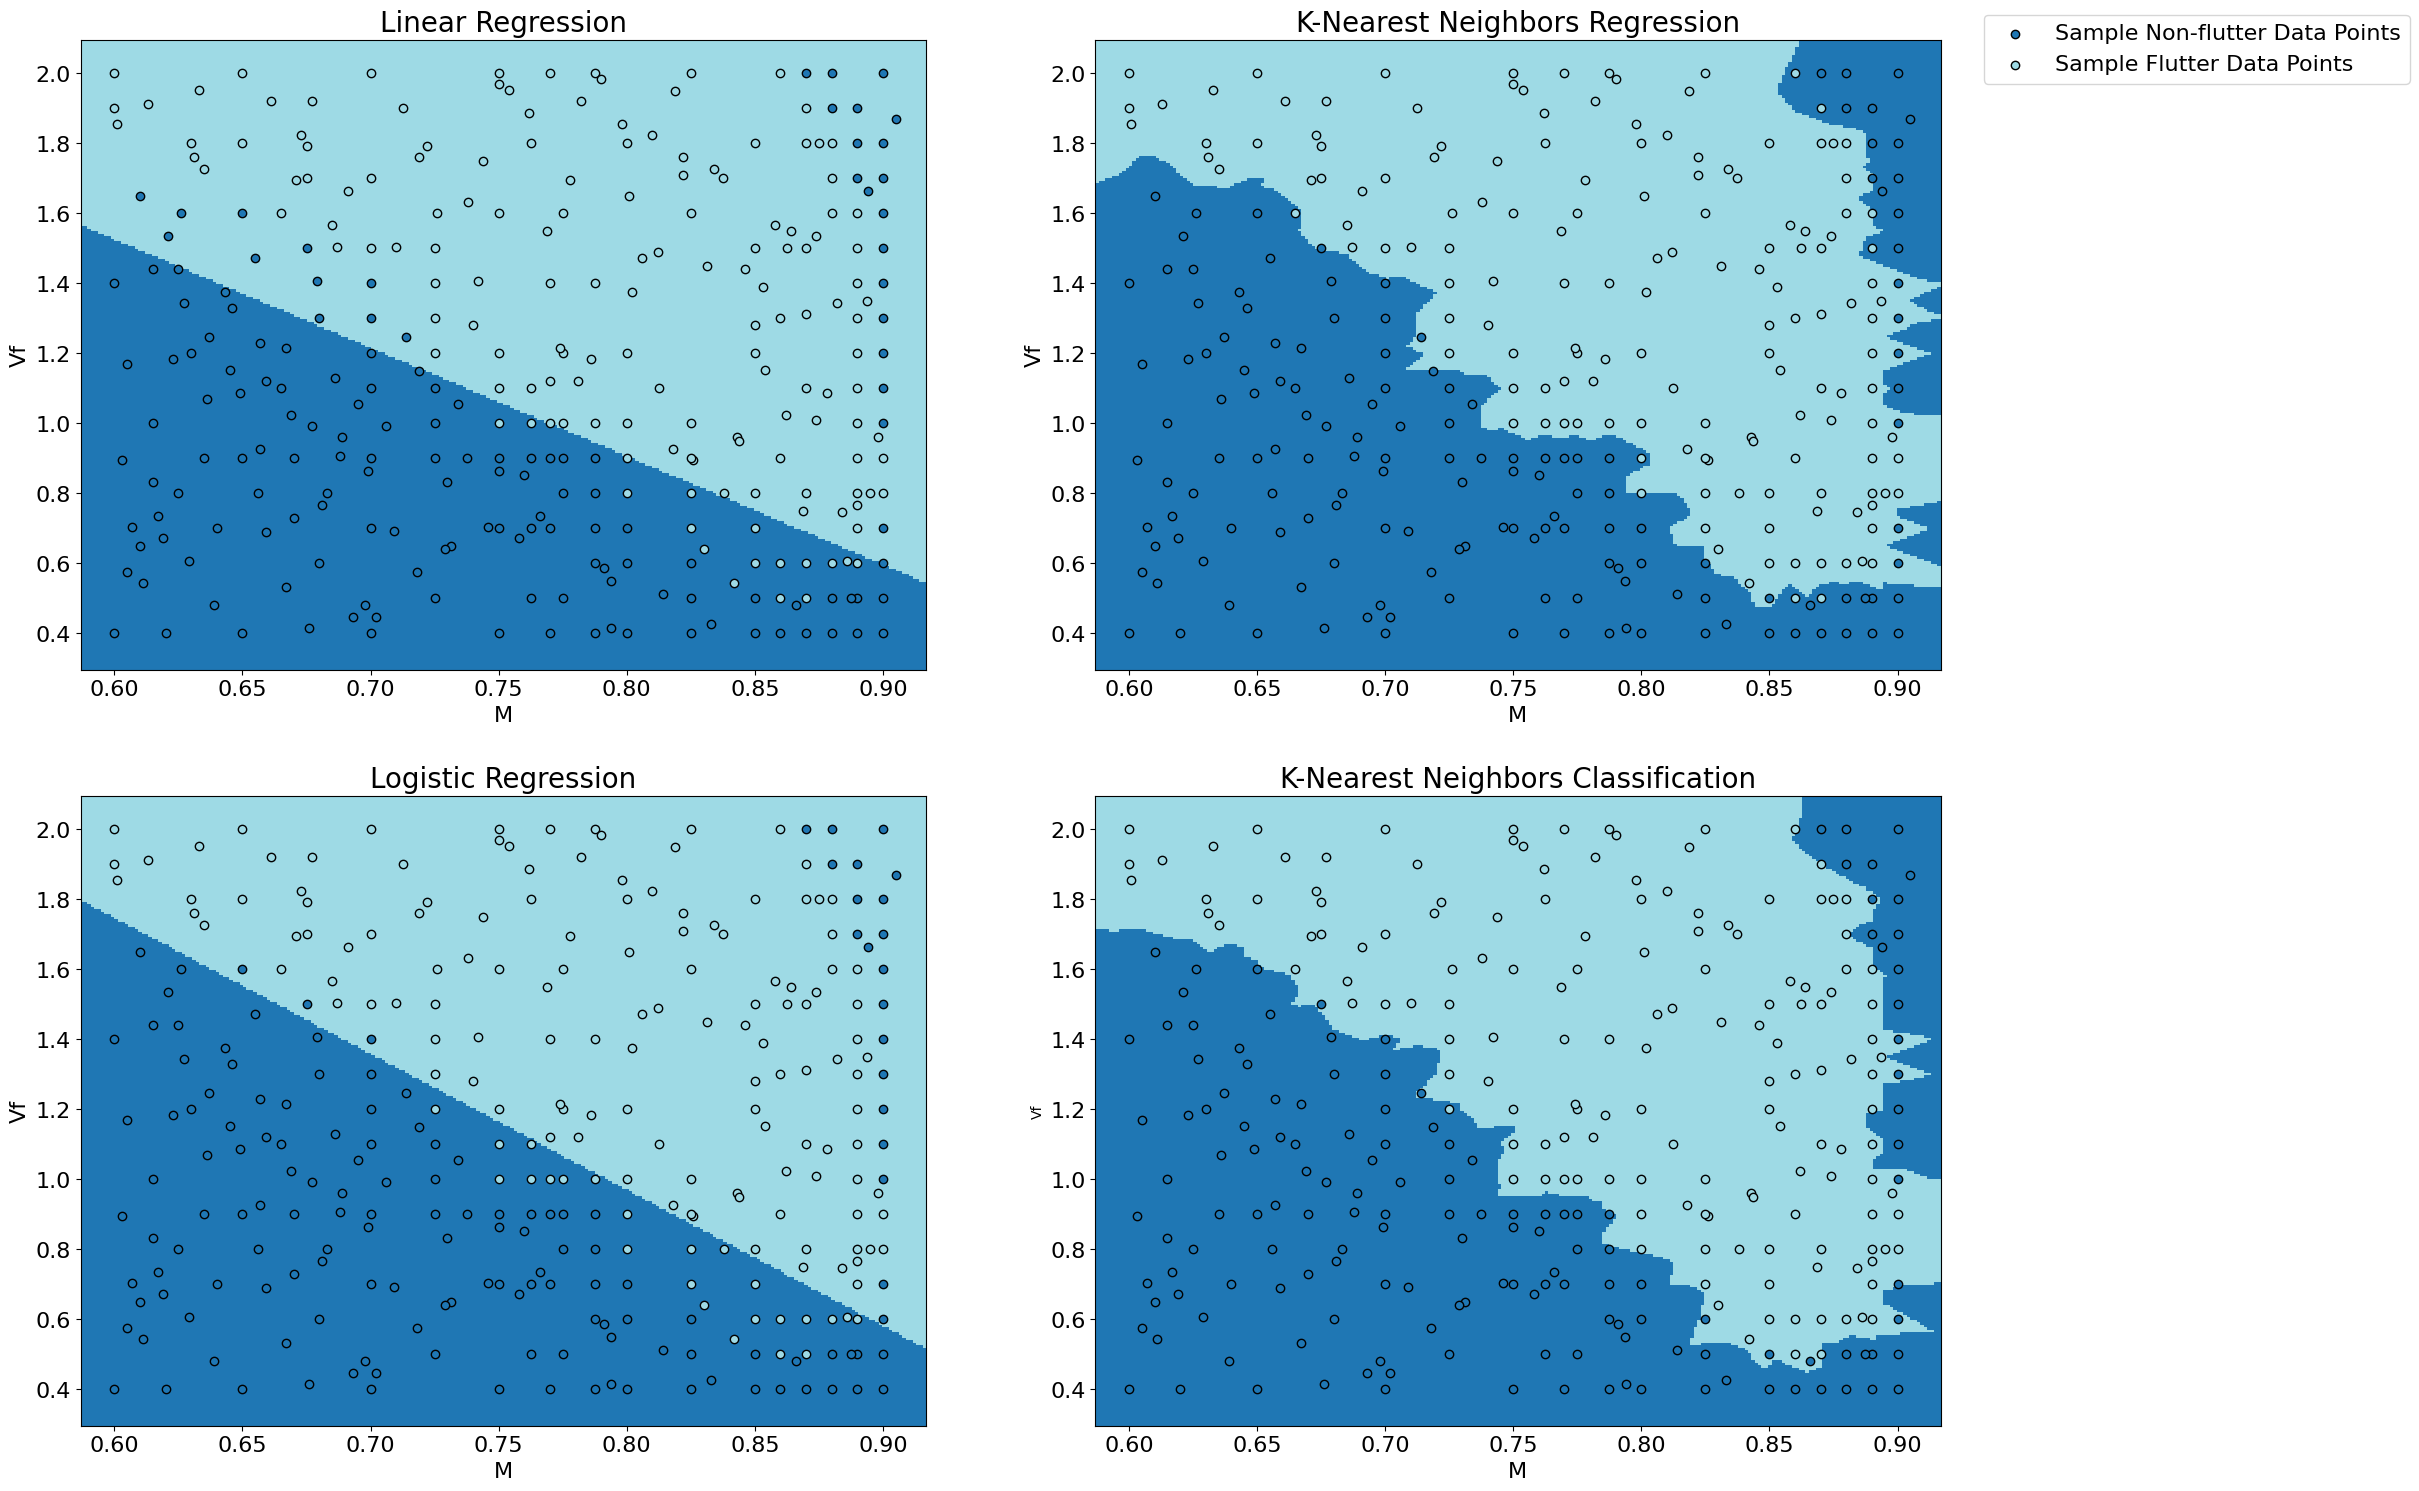

In [47]:
# Formatting the plot figure: color and size
fig = plt.figure(4, figsize=(24, 18))
ax_lr = fig.add_subplot(221)
ax_knnr = fig.add_subplot(222)
ax_logit = fig.add_subplot(223)
ax_kknc = fig.add_subplot(224)

cmap = plt.cm.tab20
plt.set_cmap(cmap)

ax_lr.pcolormesh(XX1, XX2, y_pred_mesh_lr_class)
ax_knnr.pcolormesh(XX1, XX2, y_pred_mesh_knnr_class)
ax_logit.pcolormesh(XX1, XX2, y_pred_mesh_logit)
ax_kknc.pcolormesh(XX1, XX2, y_pred_mesh_knnc)

# Plotting the result
flut = df.loc[df["DC"] < 0]
no_flut = df.loc[df["DC"] > 0]
ax_lr.scatter(no_flut["M"], no_flut["Vf"], label='Sample Non-flutter Data Points', c=cmap(0), edgecolors='k')
ax_lr.scatter(flut["M"], flut["Vf"], label='Sample Flutter Data Points', c=cmap(20), edgecolors='k')
ax_knnr.scatter(no_flut["M"], no_flut["Vf"], c=cmap(0), edgecolors='k')
ax_knnr.scatter(flut["M"], flut["Vf"], c=cmap(20), edgecolors='k')
ax_logit.scatter(no_flut["M"], no_flut["Vf"], c=cmap(0), edgecolors='k')
ax_logit.scatter(flut["M"], flut["Vf"], c=cmap(20), edgecolors='k')
ax_kknc.scatter(no_flut["M"], no_flut["Vf"], c=cmap(0), edgecolors='k')
ax_kknc.scatter(flut["M"], flut["Vf"], c=cmap(20), edgecolors='k')

# Miscellaneous information
ax_lr.set_xlabel('M')
ax_lr.set_ylabel('Vf')
ax_knnr.set_xlabel('M')
ax_knnr.set_ylabel('Vf')
ax_logit.set_xlabel('M')
ax_logit.set_ylabel('Vf')
ax_kknc.set_xlabel('M')
ax_kknc.set_ylabel('Vf')

ax_lr.set_title('Linear Regression')
ax_knnr.set_title('K-Nearest Neighbors Regression')
ax_logit.set_title('Logistic Regression')
ax_kknc.set_title('K-Nearest Neighbors Classification')

# Change title font size
ax_lr.title.set_fontsize(20)
ax_knnr.title.set_fontsize(20)
ax_logit.title.set_fontsize(20)
ax_kknc.title.set_fontsize(20)

# Change tick font size
ax_lr.tick_params(axis='both', which='major', labelsize=16)
ax_knnr.tick_params(axis='both', which='major', labelsize=16)
ax_logit.tick_params(axis='both', which='major', labelsize=16)
ax_kknc.tick_params(axis='both', which='major', labelsize=16)

# Change label font size
ax_lr.xaxis.label.set_fontsize(16)
ax_lr.yaxis.label.set_fontsize(16)
ax_knnr.xaxis.label.set_fontsize(16)
ax_knnr.yaxis.label.set_fontsize(16)
ax_logit.xaxis.label.set_fontsize(16)
ax_logit.yaxis.label.set_fontsize(16)
ax_kknc.xaxis.label.set_fontsize(16)

# Show legend once
fig.legend(bbox_to_anchor=(1.1, 0.9), prop={'size': 16})

# Export to png and svg
plt.savefig("./laporan/graph/case3_boundary.svg", format = 'svg', dpi=300, bbox_inches = 'tight')
plt.savefig("./laporan/graph/case3_boundary.png", format = 'png', dpi=300, bbox_inches = 'tight')

plt.show()

## Conclusion

$$ \textbf{TBA} $$